In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
import requests

# Define the URL of the file
url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

# Send a GET request to download the file
response = requests.get(url)

# Write the content to a local file named 'names.txt'
with open('names.txt', 'wb') as f:
    f.write(response.content)

# Read the file in read mode and split the lines into a list
words = open('names.txt', 'r').read().splitlines()

In [36]:
words = open('names.txt', 'r').read().splitlines() #converts the .txt file into a list
print(len(words))
print(max(len(w) for w in words))  
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [37]:
chars = sorted(list(set(''.join(words)))) #joins all the words into a single string, removes duplicates and converts them into a list and sorts it.
stoi = {s:i+1 for i,s in enumerate(chars)} #creates a dictionary by Creating an iterator that returns both the index (i) and the character (s) of each element in the chars list.
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} #.items() used to access and iterate through the key-value pairs of the stoi
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [38]:
import random
random.seed(42)
random.shuffle(words)

In [39]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [40]:
for x,y in zip(Xtr[:20], Ytr[:20]): #zip() takes iterables (like lists here) and combines them into a single iterable of tuples.
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [41]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1): #eps is used in denominator for numerical stability.
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2: #(batch size, features)
        dim = 0
      elif x.ndim == 3: #(batch size, sequence length, features)
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x) #-1 to 1 (activation function) #why do we use activation functions?????
    return self.out
  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) #similar to C = torch.randn((vocab_size, n_embd))

  def __call__(self, IX):
    self.out = self.weight[IX] #similar to emb = C[Xb]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:

  def __init__(self, n): #n = number of elements we want to concentate
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape #(4,8,10) #(batch size, sequence length, features)
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) #why?
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x) #this is basically the forward pass
    self.out = x
    return self.out

  def parameters(self):
    #get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [42]:
torch.manual_seed(42)

In [43]:
n_embd = 24 # Number of dimensions for token embeddings. Each token is represented as a vector of size n_embd in the embedding space.
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential ([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

#parameter init

with torch.no_grad():
  model.layers[-1].weight *= 0.1 #make the last layer less confident. This scaling is often done to adjust for specific initialization schemes or ensure proper signal propagation through the network.

parameters = model.parameters() #Collects all the trainable parameters of the model into a single list (parameters)
print(sum(p.nelement() for p in parameters)) #Computes and prints the total number of trainable parameters. Useful for debugging and estimating computational/memory requirements
for p in parameters:
  p.requires_grad = True

76579


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

  #forward pass
  logits = model(Xb) #logits are the outputs of the model
  loss = F.cross_entropy(logits, Yb) #loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # he model's parameters (weights) are updated based on the gradients computed during backpropagation.

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3088
  10000/ 200000: 2.4522
  20000/ 200000: 2.1598
  30000/ 200000: 2.6426
  40000/ 200000: 1.8248
  50000/ 200000: 2.5059
  60000/ 200000: 2.1407
  70000/ 200000: 1.8225
  80000/ 200000: 2.0721
  90000/ 200000: 1.7828
 100000/ 200000: 2.0264
 110000/ 200000: 2.0252
 120000/ 200000: 1.8361
 130000/ 200000: 1.8881
 140000/ 200000: 1.7401
 150000/ 200000: 1.9735
 160000/ 200000: 1.7228
 170000/ 200000: 1.9166
 180000/ 200000: 2.3637
 190000/ 200000: 1.7630


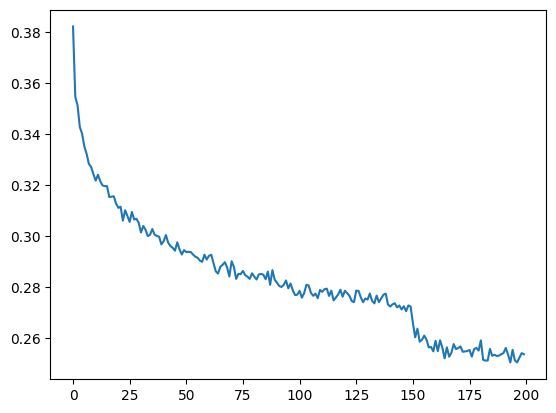

In [45]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1)) #the average loss values over chunks of 1000 iterations

In [46]:
#put layer into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [47]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits,y) #look into cross entropy
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7669140100479126
val 1.9844632148742676


In [50]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context])) # (1, block_size, n_embd)
      probs = F.softmax(logits, dim=1) #y applying softmax, you get probabilities that can be used to sample the next character.
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

rohan.
jafton.
anabella.
harleen.
ramell.
leanin.
betuan.
husain.
orlyanna.
bamy.
osyn.
jamichy.
calbisaa.
bralyn.
marykatheri.
jenami.
syrone.
pencello.
uri.
ayoam.


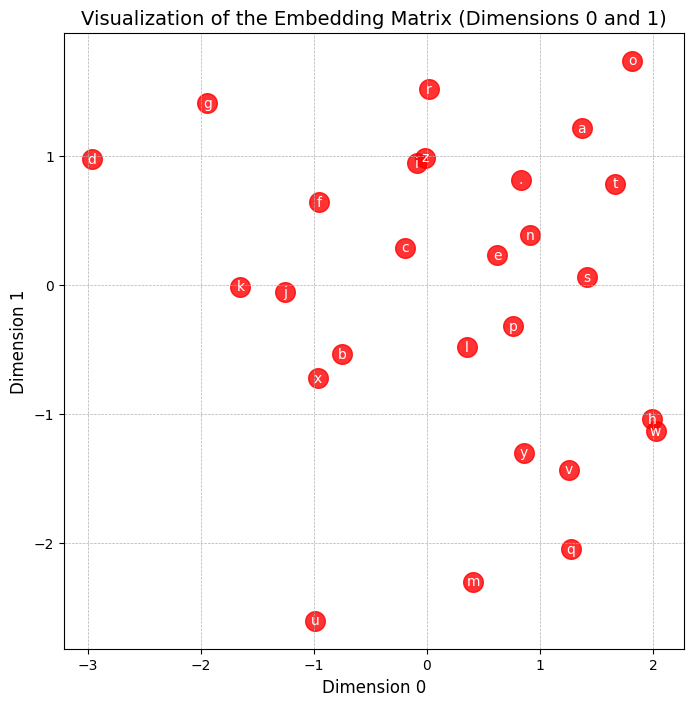

In [49]:
# Extract the embedding weights
C = model.layers[0].weight  # Assuming the Embedding layer is the first layer in your Sequential model

# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c='red', alpha=0.8)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.title("Visualization of the Embedding Matrix (Dimensions 0 and 1)", fontsize=14)
plt.xlabel("Dimension 0", fontsize=12)
plt.ylabel("Dimension 1", fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.show()
